# Forecasting Non-Stationary Time Series

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Johnson & Johnson Dataset

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


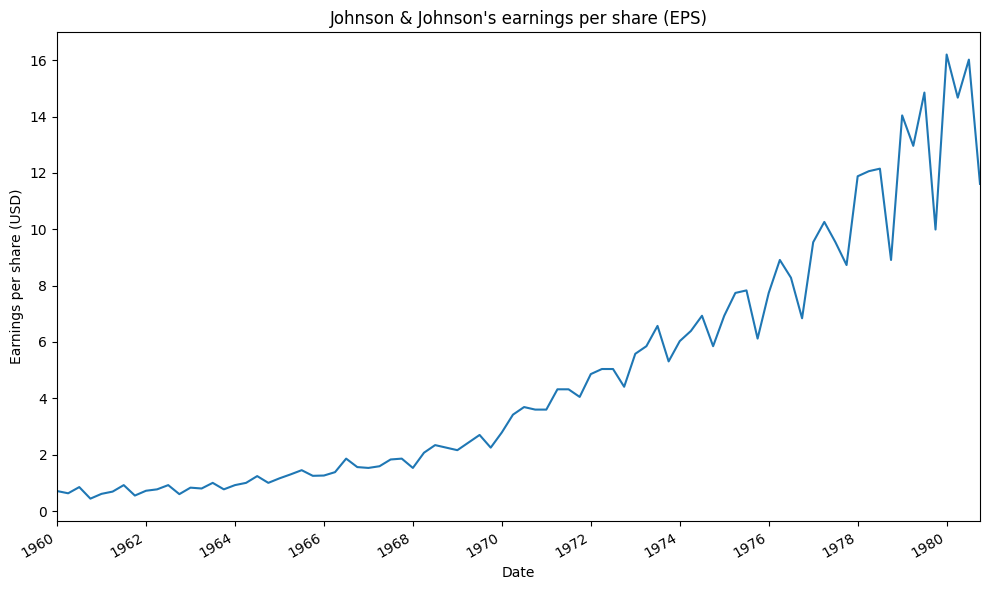

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.set_title("Johnson & Johnson's earnings per share (EPS)")
ax.set_xlim(0, 83)  # 84 points

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#### Is it Stationary?

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['data'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 2.7420165734574766
p-value: 1.0

p-value > alpha; H0: Not Stationary


We need to determine how many times the series must be differenced to become
stationary. This will then set the order of integration d. We can apply a first-order differencing and test for stationarity.

In [10]:
# First-Order differencing
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.4074097636380437
p-value: 0.9088542416911309

p-value > alpha; H0: Not Stationary


In [11]:
# Second-Order differencing
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result2 = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
print()

if ad_fuller_result2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.5851628747931694
p-value: 0.006051099869603393

p-value < alpha; Ha: Stationary


It took two rounds of differencing to make our data stationary, which means that our order of integration is 2,
so d = 2.

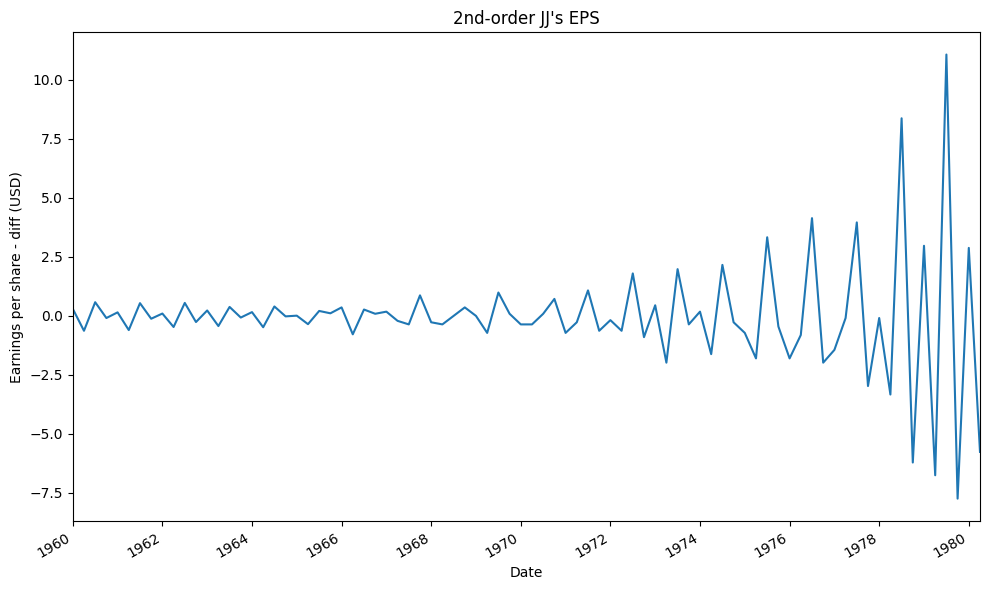

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')
ax.set_title("2nd-order JJ's EPS")
ax.set_xlim(0, 81)  # 82 points (84 - 2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

Before we move on to fitting different combinations of ARIMA(p,d,q) models, we
must separate our data into train and test sets. We will hold out the last year of data for
testing. This means that we will fit the model with data from 1960 to 1979 and predict
the quarterly EPS in 1980 to evaluate the quality of our model against the observed
values in 1980.

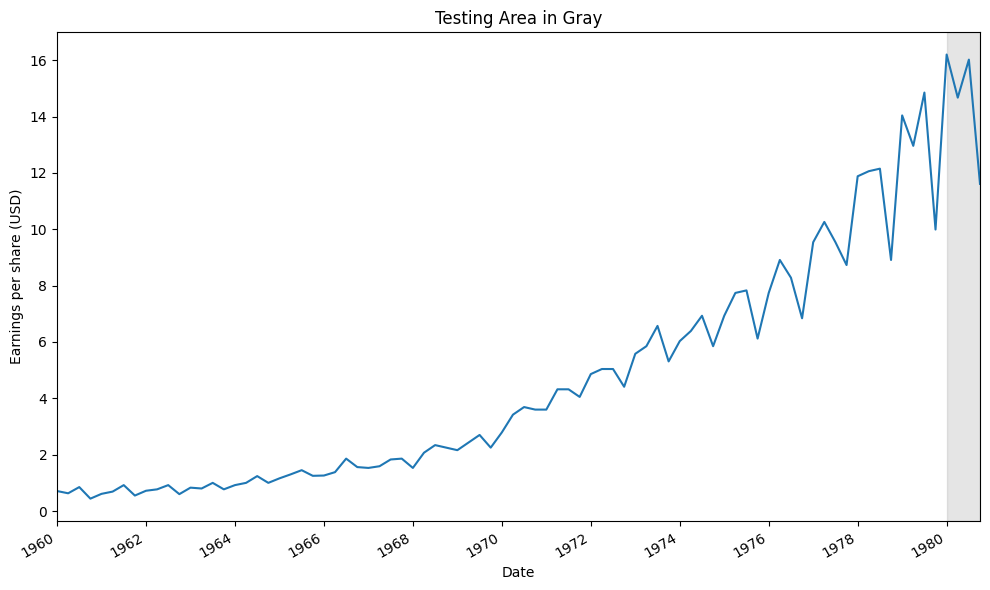

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.set_title("Testing Area in Gray")
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.set_xlim(0, 83)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

The train and test sets. The training period spans the years 1960 to 1979
inclusively, while the test set is the quarterly EPS reported in 1980. This test set
corresponds to the last four data points of the dataset.

In [63]:
train = df['data'][:-4]          # All points less the last 4 timesteps
test_series = df['data'][-4:]    # The last 4 timesteps

print(len(train))
print(len(test_series))

80
4


#### Define a range of values for p and q, and generate all unique combinations of orders (p,q).

In [19]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,d,q) combinations
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False) # Fit an ARMA(p,d,q) model using SARIMAX
        except:
            continue
            
        aic = model.aic                   # Calculate the model’s AIC.
        results.append([order, aic])      # Append the (p,q) combination and AIC as a tuple to the results list
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [20]:
ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}
d = 2                               # Number of derivatives until Stationy

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

####  Fit all unique ARIMA(p,d,q) models to extract the AIC values

In [22]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.270561
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430627
4,"(0, 3)",194.654716
5,"(0, 2)",209.274484
6,"(2, 3)",220.666938
7,"(1, 3)",228.267935
8,"(1, 2)",228.935814
9,"(2, 2)",229.974707


#### Fit the model

In [24]:
# Define a SARIMAX model with specified AR(3), I(2), MA(3) parameters
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)

# Fit the model
model_fit = model.fit(disp=False)

# Display the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.635
Date:                Fri, 14 Feb 2025   AIC                            115.271
Time:                        09:36:20   BIC                            131.768
Sample:                             0   HQIC                           121.875
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9990      0.037    -27.164      0.000      -1.071      -0.927
ar.L2         -0.9876      0.040    -24.869      0.000      -1.065      -0.910
ar.L3         -0.9762      0.026    -38.131      0.000      -1.026      -0.926
ma.L1         -0.7967      0.120     -6.652      0.000      -1.031      -0.562
ma.L2          0.2448      0.147      1.669      0.095      -0.043       0.532
ma.L3         -0.2018      0.145     -1.392      0.164      -0.486       0.082
sigma2         0.1842      0.023      8.125      0.000       0.140       0.229
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                42.25
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):              51.30   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals

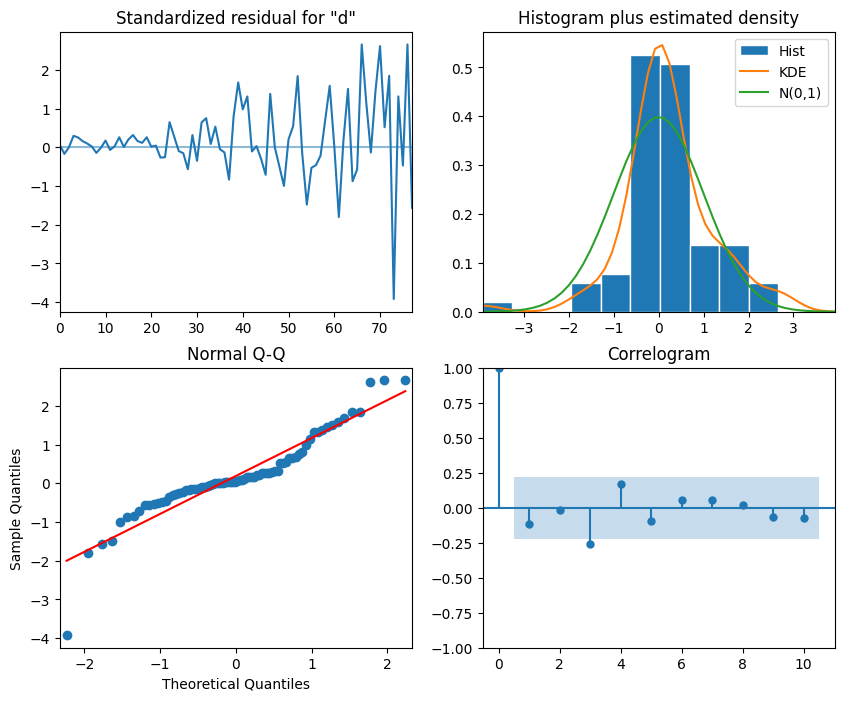

In [26]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit.resid 

# Diagnostic plots for the model, including residuals and other model checks
model_fit.plot_diagnostics(figsize=(10,8));

The **top-left** plot shows the residuals over time. While there is no trend in
the residuals, the variance does not seem to be constant, which is a discrepancy in
comparison to white noise. 

At the **top right** is the distribution of the residuals. We can
see it is fairly close to a normal distribution. 

The **Q-Q plot** leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution
is close to a normal distribution. 

Finally, by looking at the correlogram at the **bottom
right**, we can see that a coefficient seems to be significant at lag 3. However, since it is
not preceded by any significant autocorrelation coefficients, we can assume that this is
due to chance. Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise.

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,1.669504,0.196325
2,1.670686,0.433726
3,7.247716,0.064408
4,9.200575,0.056277
5,9.828924,0.080230
6,10.064819,0.121949
7,10.319878,0.171159
8,10.351977,0.241185
9,10.696263,0.297104
10,11.137740,0.346888


    Our ARIMA(3,2,3) model has passed all the checks, and it can now be used for forecasting.

The naive seasonal forecast is implemented by selecting the quarterly EPS reported in 1979 and using the same values as a forecast for the year 1980.

In [61]:
# The test set corresponds to the last four data points.
test = df.iloc[-4:]

# the quarterly EPS reported in 1979
test['naive_seasonal'] = df['data'].iloc[76:80].values

test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


With our baseline in place, we can now make forecasts using the ARIMA(3,2,3) model and store the results in the ARIMA_pred column.

In [66]:
# Get the ARIMA model's prediction for the given time period (80 to 83) using the fitted model
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean  

# Assign the predicted ARIMA values to the 'ARIMA_pred' column in the test DataFrame
test['ARIMA_pred'] = ARIMA_pred  

# Display test
test  

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.857834
81,1980-04-01,14.67,12.96,14.379995
82,1980-07-02,16.02,14.85,16.371491
83,1980-10-01,11.61,9.99,11.678241


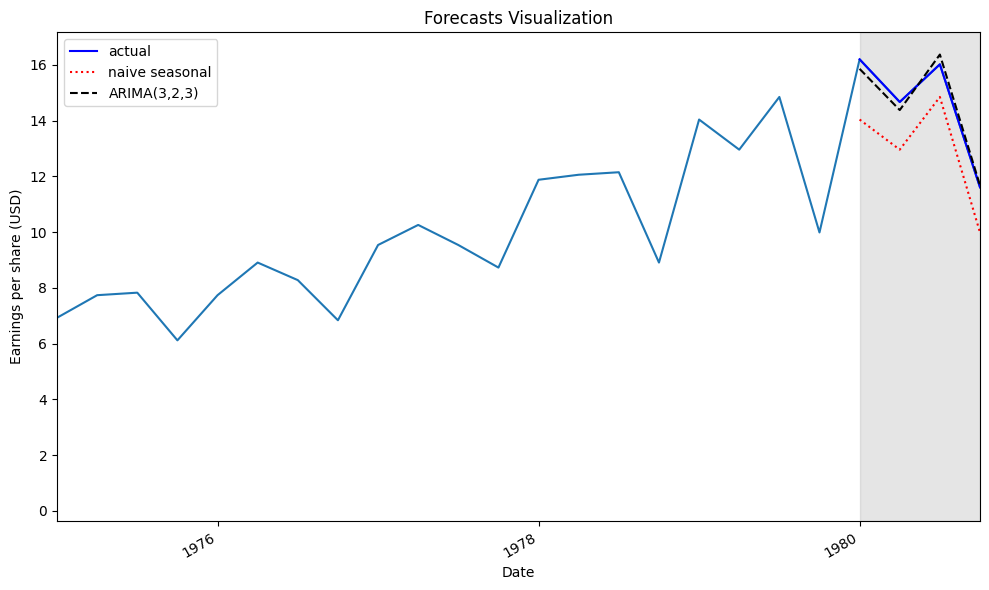

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
ax.set_title('Forecasts Visualization')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

*Forecasts of the quarterly EPS of Johnson & Johnson in 1980. We can see
that the predictions coming from the ARIMA(3,2,3) model, shown as a dashed line,
almost perfectly overlap the observed data in 1980.*